In [1]:
# Step 1: Modules are imported
import wave
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

# Step 2: Define sequence length
sequence_length = 10

# Step 3: Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Step 4: build GRU Architecture
model = keras.Sequential()

# Add a GRU layer with 3 units.
model.add(layers.GRU(1,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(sequence_length, 1)))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))

# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Step 5: Initialize tables for ADPCM encoding
import random
IndexTable = [-1, -1, -1, -1, 2, 4, 6, 8, -1, -1, -1, -1, 2, 4, 6, 8]
StepSizeTable = [7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 23, 25, 28, 31, 34, 37, 41, 45, 50, 55, 60, 66, 73, 80, 88, 97, 107, 118, 130, 143, 157, 173, 190, 209, 230, 253, 279, 307, 337, 371, 408, 449, 494, 544, 598, 658, 724, 796, 876, 963, 1060, 1166, 1282, 1411, 1552, 1707, 1878, 2066, 2272, 2499, 2749, 3024, 3327, 3660, 4026, 4428, 4871, 5358, 5894, 6484, 7132, 7845, 8630, 9493, 10442, 11487, 12635, 13899, 15289, 16818, 18500, 20350, 22385, 24623, 27086, 29794, 32767]

# Global variables for ADPCM encoding and decoding
index = 0
#predicted_samples = [0] * sequence_length  # Initialize with zeros for the sequence
import random
predicted_samples = [random.uniform(-32768, 32767) for _ in range(sequence_length)]

predicted_sample = 0
de_index = 0
de_predicted_samples = [0] * sequence_length
de_predicted_sample = 0 
diffq = 0
encoded_values = []
decoded_values = []

In [2]:
# Step 6: ADPCM_Encode function with GRU predictor
def ADPCM_Encode(sample):
    global index, diffq, encoded_values, predicted_sample

    # Predict and update the model
    predicted_sample = predict_and_update_model(sample)  

    # Calculate the difference between the predicted and actual sample
    diff = sample - predicted_sample

    code = 0
    step_size = StepSizeTable[index]

    # Encoding logic
    if diff < 0:
        code = 8
        diff = -diff

    tmpstep = step_size
    diffq = step_size >> 3

    if diff >= tmpstep:
        code = code | 0x04
        diff -= tmpstep
        diffq = diffq + step_size

    tmpstep = tmpstep >> 1

    if diff >= tmpstep:
        code = code | 0x02
        diff = diff - tmpstep
        diffq = diffq + (step_size >> 1)

    tmpstep = tmpstep >> 1

    if diff >= tmpstep:
        code = code | 0x01
        diffq = diffq + (step_size >> 2)

    encoded_values.append(code)

    # Rest of the ADPCM encoding logic
    if code & 8:
        predicted_sample = predicted_sample - diffq
    else:
        predicted_sample = predicted_sample + diffq

    if predicted_sample > 32767:
        predicted_sample = 32767
    elif predicted_sample < -32768:
        predicted_sample = -32768
     
    
    index += IndexTable[code]

    if index < 0:
        index = 0

    if index > 88:
        index = 88
    return code & 0x0f, predicted_sample

# Step 7: Function to predict and update model
def predict_and_update_model(sample):
    global predicted_samples, model
    
    # Predict the next sample using the GRU model
    predicted_samples = np.array(predicted_samples).reshape(1, sequence_length, 1)
    predicted_sample = model.predict(predicted_samples, verbose=0)[0][0]
    
    # Sample to add
    new_sample = np.array([[[predicted_sample]]])  # Adjust the value as needed
    
    # Add the new sample and remove the oldest sample
    predicted_samples = np.concatenate((predicted_samples[:, 1:], new_sample), axis=1)
    
    # Reshape the sequence data
    X = np.array(predicted_samples)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    Y = np.array([sample])
    Y = Y.reshape(Y.shape[0], 1)
    model.fit(X, Y, epochs=1, verbose=0)
    
    return predicted_sample

In [3]:
# Step 8: Decoding from ADPCM to PCM with Online GRU Predictor
def ADPCM_Decode(code):
    global de_index, de_predicted_sample, decoded_values

    step_size = StepSizeTable[de_index]

    # Inverse code into diff remains the same
    diffq = step_size >> 3  # Equivalent to step_size / 8

    if code & 4:
        diffq += step_size

    if code & 2:
        diffq += step_size >> 1

    if code & 1:
        diffq += step_size >> 2

    # Add diff to predicted sample
    if code & 8:
        diffq = -diffq
    
    # Update the RNN model with the current sample
    de_predicted_sample = de_predict_and_update_model(de_predicted_sample)
    
    # Update the predicted sample list
    de_predicted_sample += diffq
      
    # Check for overflow and clip the values to 16 bits
    if de_predicted_sample > 32767:
        de_predicted_sample = 32767
    elif de_predicted_sample < -32768:
        de_predicted_sample = -32768

    de_index += IndexTable[code]

    if de_index < 0:
        de_index = 0

    if de_index > 88:
        de_index = 88   

    return de_predicted_sample
       
#Step 9: Function to predict and update model
def de_predict_and_update_model(de_predicted_sample):
    global de_predicted_samples, model

    # Predict the next sample using the RNN model
    de_predicted_samples = np.array(de_predicted_samples).reshape(1, sequence_length, 1)
    de_predicted_sample = model.predict(de_predicted_samples, verbose=0)[0][0]

    # Sample to add
    new_sample = np.array([[[de_predicted_sample]]])  # Adjust the value as needed

    # Add the new sample and remove the oldest sample
    de_predicted_samples = np.concatenate((predicted_samples[:, 1:], new_sample), axis=1)

#     # Reshape the sequence data
#     X = np.array(de_predicted_samples)
#     X = X.reshape(X.shape[0], X.shape[1], 1)

#     Y = np.array([de_predicted_sample])
#     Y = Y.reshape(Y.shape[0], 1)
#     model.fit(X, Y, epochs=1, verbose=0)
    
    return de_predicted_sample

In [4]:
#Step 10: Loading Test Audio Data
Test_audio_file = 'dataset_8000/test.wav'
fs, Test_data = wavfile.read(Test_audio_file)
test_input = Test_data[:50]

In [5]:
encoded_values = []
decoded_values = []
predicted_values = []

# Encode the test input
for sample in test_input:
    code, predicted_sample = ADPCM_Encode(sample)
    decoded_value = ADPCM_Decode(code)
    
    encoded_values.append(code)
    decoded_values.append(decoded_value)   
    predicted_values.append(predicted_sample)   
    
encoded_values = np.array(encoded_values)
decoded_values = np.array(decoded_values)
predicted_values = np.array(predicted_values)

In [6]:
# Normalize Data Between -1 and 1

# Find the minimum and maximum values for the original speech data
min_val = min(test_input)
max_val = max(test_input)

# Normalize the data between -1 and 1
test_input = np.array([(2 * (x - min_val) / (max_val - min_val)) - 1 for x in test_input])

# Create an array for x values (assuming evenly spaced)
x_val = np.arange(len(test_input))


########################################################################################

# Find the minimum and maximum values for the predicted speech data
min_val_pre = min(predicted_values)
max_val_pre = max(predicted_values)

# Normalize the data between -1 and 1
predicted_values = np.array([(2 * (x - min_val_pre) / (max_val_pre - min_val_pre)) - 1 for x in predicted_values])

# Create an array for x values (assuming evenly spaced)
x_val_1 = np.arange(len(predicted_values))


########################################################################################

# Find the minimum and maximum values for the predicted speech data
min_val_dec = min(decoded_values)
max_val_dec = max(decoded_values)

# Normalize the data between -1 and 1
decoded_values = np.array([(2 * (x - min_val_dec) / (max_val_dec - min_val_dec)) - 1 for x in decoded_values])

# Create an array for x values (assuming evenly spaced)
x_val_2 = np.arange(len(decoded_values))

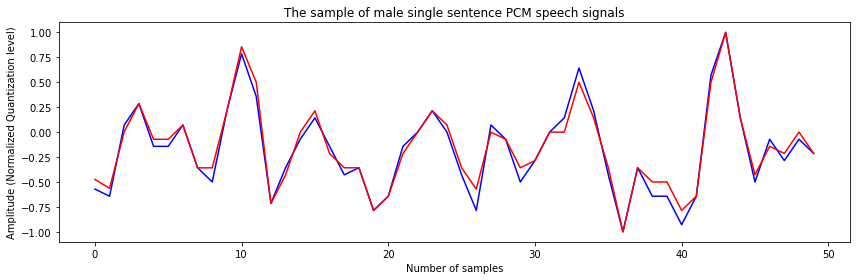

In [7]:
# Plot original signal, predicted signal, and decoded signal

plt.figure(figsize=(12, 4))
# Oreginal speech signal data
plt.title('The sample of male single sentence PCM speech signals') 
plt.plot(test_input[:], 'b', label='Original Signal sample')

# # Predicted speech signal data
# plt.xlabel('Number of samples')
# plt.ylabel('Amplitude (Normalized Quantization level)')
# plt.plot(decoded_values[:], 'g', label='predict Signal sample')

# Predicted speech signal data
plt.xlabel('Number of samples')
plt.ylabel('Amplitude (Normalized Quantization level)')
plt.plot(predicted_values[:], 'r', label='predict Signal sample')

plt.tight_layout()
plt.show()

online-RNN predictor SNR: 15.323132048237593 dB


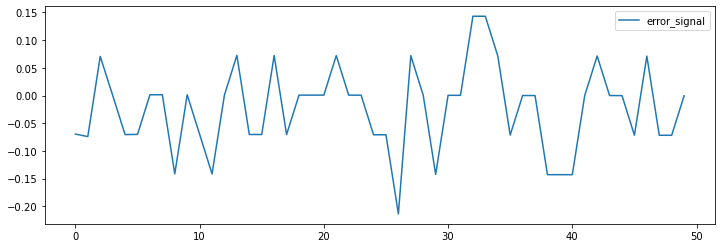

In [8]:
# Step 11: SNR Based Evaluation

# Calculate the error signal
error_signal = test_input - decoded_values

# Create a plot to visualize the error signal
plt.figure(figsize=(12, 4))
plt.plot(error_signal, label = 'error_signal')
plt.legend()

# Calculate SNR metrics
fixed_mse = 10 * np.log10(np.mean(pow(np.abs(error_signal[:]), 2)))
fixed_sigpow = 10 * np.log10(np.mean(pow(np.abs(test_input), 2)))

# Print the SNR result
print("online-RNN predictor SNR:", fixed_sigpow - fixed_mse, "dB")